# Predizione della cancellazione di una prenotazione
**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Asia Lucchi

In [562]:
#installazioni
#usando Anaconda:
#%conda install tensorflow keras

#altrimenti:
#%pip install keras

In [563]:
#setup librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import keras
import warnings
warnings.filterwarnings('ignore')

## Descrizione del problema e comprensione dei dati
- Il progetto ha come obiettivo di predirre se una **prenotazione in albergo verrà cancellata o meno** mediante l'utilizzo del Dataset _Hotel Booking Demand_ presente su Kaggle (https://www.kaggle.com/jessemostipak/hotel-booking-demand).
- Nel Dataset sono presenti 119k istanze con le prenotazioni riguardanti soggiorni aventi data di arrivo compresa fra l'1 Luglio 2015 e il 31 Agosto 2017 in hotel portoghesi, ogni istanza è composta da 32 feature.

In [564]:
import os.path
if not os.path.exists("hotel_bookings.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://tinyurl.com/y7cw9z3f", "hotel_bookings.csv")

In [565]:
hbookings = pd.read_csv('hotel_bookings.csv')

In [566]:
hbookings.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Lista delle variabili

- __hotel__: tipologia hotel, può essere resort o in città
- __lead_time__: numero di giorni trascorsi fra la prenotazione e il giorno di arrivo in albergo
- __arrival_date_year__: anno della data di arrivo in albergo
- __arrival_date_month__: mese (January-December) della data di arrivo in albergo
- __arrival_date_week_number__: numero della settimana dell'anno (1-52) della data di arrivo in albergo
- __arrival_date_day__: giorno di arrivo nel mese (1-31) della data di arrivo in albergo
- __stays_in_weekend_nights__: numero di notti della prenotazione che riguardano il weekend (sabato o domenica)
- __stays_in_week_nights__: numero di notti della prenotazione che riguardano giorno feriali (lunedì - venerdì)
- __adults__: numero di adulti
- __children__: numero di bambini
- __babies__: numero di bambini piccoli
- __meals__: pasti compresi nella prenotazione
    - BB (Bed&Breakfast): solamente la colazione
    - HB (Half Board): colazione e cena
    - SC (Self Catering): nessun pasto incluso, utensili e fornello a disposizione per cucinare
    - FB (Full Board): colazione, pranzo e cena
    - Undefined
- __country__: nazione di provenienza del cliente
- __market_segment__: 'gruppo' a cui appartiene il cliente che ha prenotato in base alla segmentazione del mercato
    - Online TA: agenzia di viaggio online
    - Offline TA/TO: agenzia di viaggio o tour operator
    - Groups: gruppo di viaggio
    - Corporate: azienda
    - Direct: diretta da parte dell'interessato
- __distribution_channel__: canale attraverso il quale è stata effettuata la prenotazione
    - TA/TO: Tour Operator o agenzia viaggi
    - Direct: direttametne dall'interessato contattando l'albergo
    - Corporate: dall'azienda
    - GDS: attraverso un sisteam informatico Global Distribution System 
    - Undefined
- __is_reapeated_guest__: variabile binaria che indica se il cliente ha già alloggiato nell'hotel
- __previous_cancellations__: numero di cancellazioni effettuate dal cliente in precedenza
- __previous_bookings_not_canceled__: numero di prenotazioni seguite da un effettivo soggiorno effettuate dal cliente
- __reserved_room_type__: codice (A-G) che indica il tipo di camera prenotata, indicato come codice per anonimità
- __assigned_room_type__: codice (A-G) che indica il tipo di camera realmente asseganta, indicato come codice per anonimità e a volte diversa da quella prenotata per richiesta dell'utente o overbooking
- __booking_changes__: numero di modifiche fatte alla prenotazione
- __deposit_type__: indica se è stato effettuato qualche tipo di pagamento al momento della prenotazione
    - No Deposit: nessun pagamento
    - No Refund: pagamento del'intera somma
    - Refundable: pagamento di una caparra (non presente nel dataset)
- __agent__: ID della agenzia viaggi che ha fatto la prenotazione
- __company__: ID della compagnia o dell'entità che ha fatto la prenotazione o è responsabile per il pagamento
- __days_in_waiting_list__: giorni che ha atteso l'utente prima di ricevere la conferma della prenotazione
- __customer_type__: tipo di prenotazione
    - Contract: fatto tramite un contratto, solitmente con un tour operator
    - Group: associata a un gruppo
    - Transient: semplici ospiti che richiedono un soggiorno
    - Transiente-party: semplici ospiti che richiedono un soggiorno last-minute e/o breve, walk-int 
- __adr__: Average Daily Rate, media delle 'lodging transactions' per notte di soggiorno
- __required_car_parking_spaces__: numero di parcheggi richiesti dal cliente
- __total_of_special_requests__: numero di richieste particolari fatte dall'owner ad esempio letti singoli o un piano alto nel palazzo
- __reservation_status__: stato finale della prenotazione
    - Canceled: cancellata
    - Check-Out: soggiorno effettuato
    - No-Show: il cliente non si è presentato senza fornire spiegazioni
- __reservation_status_date__: data in cui è stato impostato l'ultimo status della prenotazione, nel caso di cancellazione è la data di cancellazione, nel caso di soggiorno la data del check-out
- **is_canceled**: _variabile discreta binaria che indica se la prenotazione è stata cancellata_
    - vogliamo stimare il valore di questa variabile in funzione delle altre

# Analisi Esplorativa
- I dati raccolti ci permettono di ricavare svariate informazioni sulle abitudini di cancellazione dei clienti.
- Possiamo iniziare a valutare il problema visualizzando alcune informazioni sulle prenotazioni cancellate, ad esempio la quantità e la percentuale.
    - Graficamente possiamo visualizzare tali informazioni in un grafico a torta.

In [567]:
hbookings['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [568]:
hbookings['is_canceled'].mean()

0.37041628277075134

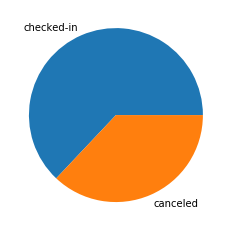

In [569]:
plt.pie(hbookings['is_canceled'].value_counts(), labels = ['checked-in', 'canceled']);

- Possiamo anche vedere tutte le statistiche delle colonne in formato numerico che ci sono fornite...

In [570]:
hbookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


... e come queste statistiche cambiano nel caso in cui di concentriamo solo sui dati riguardanti prenotazioni cancellate:

In [571]:
chbookings = hbookings[hbookings['is_canceled'] == 1].drop(columns='is_canceled')
chbookings.describe()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,44224.000000,44224.000000,44224.000000,44224.000000,44224.000000,44224.000000,44224.000000,44220.000000,44224.000000,44224.000000,44224.000000,44224.000000,44224.000000,40194.000000,1191.000000,44224.000000,44224.000000,44224.0,44224.000000
mean,144.848815,2016.171920,27.309696,15.728066,0.925267,2.561912,1.901728,0.106513,0.003821,0.012482,0.208348,0.025122,0.098340,75.179927,183.371117,3.564083,104.964333,0.0,0.328826
std,118.624829,0.714557,13.083155,8.787969,1.007468,1.878296,0.678038,0.411352,0.062429,0.111024,1.332346,0.678941,0.451008,104.589834,128.226814,21.488768,52.571142,0.0,0.649234
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.0,0.000000
25%,48.000000,2016.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,67.000000,0.000000,72.415000,0.0,0.000000
50%,113.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,169.000000,0.000000,96.200000,0.0,0.000000
75%,214.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,149.000000,270.000000,0.000000,127.620000,0.0,0.000000
max,629.000000,2017.000000,53.000000,31.000000,16.000000,40.000000,55.000000,10.000000,2.000000,1.000000,26.000000,58.000000,16.000000,531.000000,543.000000,391.000000,5400.000000,0.0,5.000000


- Possiamo vedere i valori distinti di ciascuna feature.

In [572]:
hbookings.nunique()

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              333
company                            352
days_in_waiting_list     

- Visualizziamo la distribuzione di alcune variabili non binarie del Dataset.

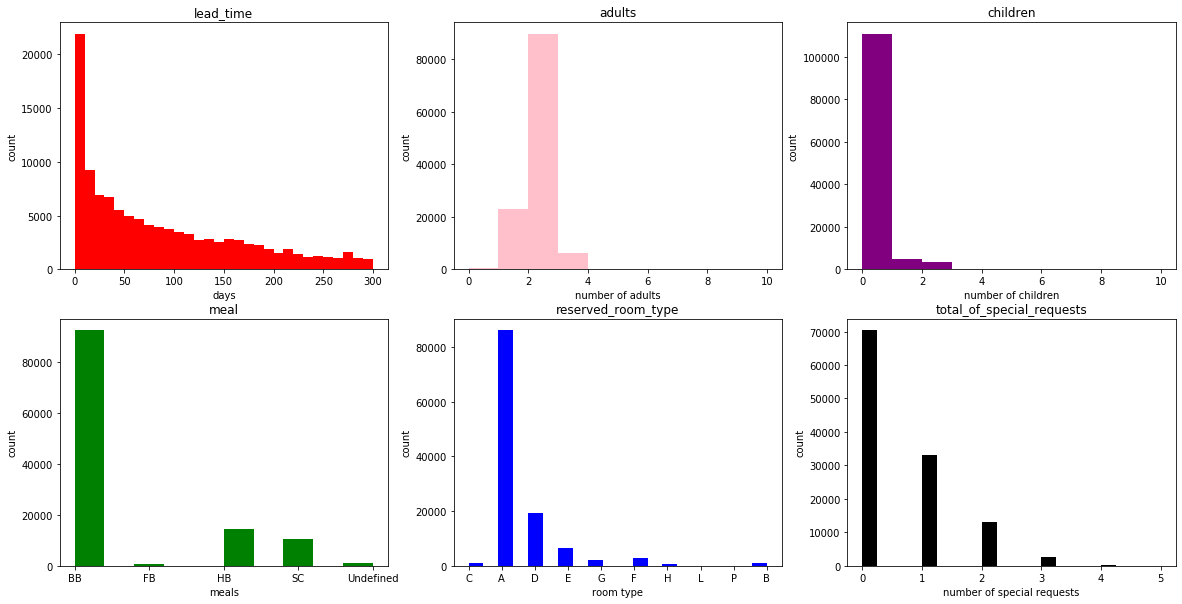

In [573]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('lead_time')
plt.hist(hbookings['lead_time'], label="lead_time", color='red', bins=30, range=(0, 300))
plt.ylabel('count')
plt.xlabel('days')

plt.subplot(2, 3, 2)
plt.title('adults')
plt.hist(hbookings['adults'], label="adults", color='pink', bins=10, range=(0, 10))
plt.ylabel('count')
plt.xlabel('number of adults')

plt.subplot(2, 3, 3)
plt.title('children')
plt.hist(hbookings['children'], label="children", color='purple', bins=10, range=(0, 10))
plt.ylabel('count')
plt.xlabel('number of children')

plt.subplot(2, 3, 4)
plt.title('meal')
plt.hist(hbookings['meal'], label="meal", color='green')
plt.ylabel('count')
plt.xlabel('meals')

plt.subplot(2, 3, 5)
plt.title('reserved_room_type')
plt.hist(hbookings['reserved_room_type'], label="reserved_room_type", color='blue', bins=20)
plt.ylabel('count')
plt.xlabel('room type')

plt.subplot(2, 3, 6)
plt.title('total_of_special_requests')
plt.hist(hbookings['total_of_special_requests'], label="total_of_special_requests", color='black', bins=20)
plt.ylabel('count')
plt.xlabel('number of special requests');

- Si può notare che:
    - Le prenotazioni vengono effettuate più di frequente a ridosso del soggiorno, la maggior parte meno di 10 giorni prima.
    - Solitamente le prenotazioni sono per due adulti, ma ci sono abbastanza casi anche per un solo adulto o 3 adulti.
    - La maggior parte delle prenotazioni non include bambini.
    - Una grandissima quantità di prenotazioni sono di tipo BB per quanto riguarda i pasti, mentre ce ne sono molto poche di tipo HB.
    - La stanza di tipo A è di gran lunga quella richiesta più frequentemente.
    - Nella maggior parte delle prenotazioni non ci sono richieste speciali.

## Analisi dell'importanza delle feature 'arrival_date_month' e 'country'
### _arrival_date_month_
- Possiamo calcolare il numero di cancellazioni per mese.

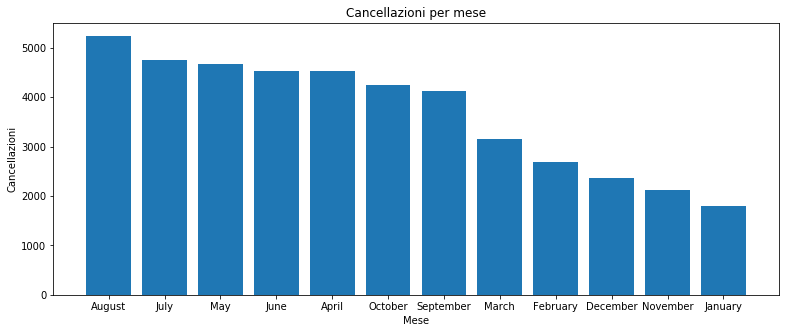

In [574]:
from matplotlib.pyplot import figure
plt.figure(figsize=(13,5))
plt.bar(chbookings['arrival_date_month'].value_counts().index, chbookings['arrival_date_month'].value_counts());
plt.title("Cancellazioni per mese")
plt.xlabel("Mese")
plt.ylabel("Cancellazioni");

- Sembra che per Agosto avvengano un sacco di cancellazioni.
- Per avere una visione più completa vediamo i mesi di presunto inizio soggiorno in cui il numero di cancellazioni in percentuale è stato più alto.

In [575]:
cmonths = chbookings['arrival_date_month'].value_counts() / hbookings['arrival_date_month'].value_counts()
cmonths

April        0.407972
August       0.377531
December     0.349705
February     0.334160
January      0.304773
July         0.374536
June         0.414572
March        0.321523
May          0.396658
November     0.312334
October      0.380466
September    0.391702
Name: arrival_date_month, dtype: float64

- Questi dati possono essere normalizzati per evidenziare meglio le differenze.

In [576]:
(cmonths-cmonths.min())/(cmonths.max()-cmonths.min())

April        0.939891
August       0.662650
December     0.409221
February     0.267640
January      0.000000
July         0.635371
June         1.000000
March        0.152554
May          0.836854
November     0.068865
October      0.689379
September    0.791708
Name: arrival_date_month, dtype: float64

- Si può notare che le prenotazioni in Giugno, Aprile, Maggio e Settembre sono quelle più incerte mentre si può fare più affidamento sulle prenotazioni in Gennaio, Novembre o Marzo.
- Il numero di cancellazioni ad Agosto che nel primo grafico è più alto in realtà non è particolarmente rilevante perchè ad Agosto ci sono anche molto più prenotazioni rispetto ad altri mesi, infatti la percentuale di cancellazioni è perfettamente nella media.
- Sebbene dal primo grafico sembri che a Marzo ci siano più cancellazioni che a Febbraio, in realtà si può considerare più affidabile perchè anche il numero di prenotazioni è nettamente maggiore.

In [577]:
hbookings['arrival_date_month'].value_counts()['February']

8068

In [578]:
hbookings['arrival_date_month'].value_counts()['March']

9794

- La probabilità di cancellazione per mese si può valutare visivamente nel seguente grafico.

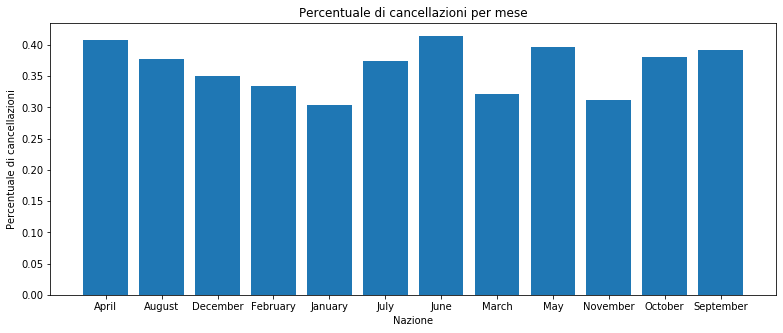

In [579]:
plt.figure(figsize=(13,5))
plt.bar(cmonths.index, cmonths);
plt.title("Percentuale di cancellazioni per mese")
plt.xlabel("Nazione")
plt.ylabel("Percentuale di cancellazioni");

### _country_
- Un ragionamento analogo si può fare ad esempio con i paesi di provenienza.
- Prendiamo in considerazione solamente i 20 paesi da cui vengono effettuate prenotazioni più di frequente.

In [580]:
countries = hbookings['country'].value_counts()[:20].index
chcountries_bookings = chbookings[chbookings['country'].isin(countries)]

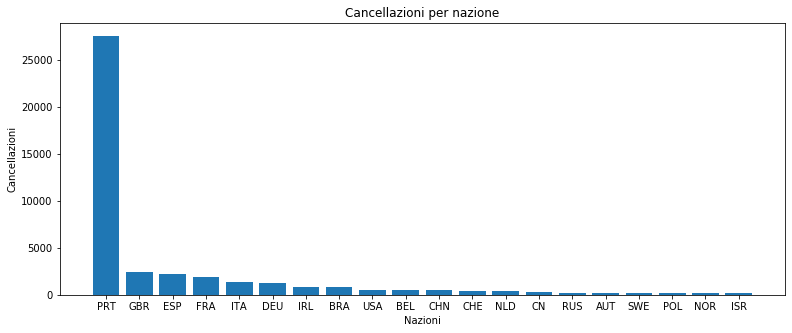

In [581]:
plt.figure(figsize=(13,5))
plt.bar(chcountries_bookings['country'].value_counts().index, chcountries_bookings['country'].value_counts())
plt.title("Cancellazioni per nazione")
plt.xlabel("Nazioni")
plt.ylabel("Cancellazioni");

- Le cancellazioni sono fortemente sbilanciate in favore del Portogallo in quanto gli hotel presi in considerazione sono portoghesi perciò anche il numero delle prenotazioni totali è in favore del Portogallo.

In [582]:
hbookings[hbookings['country'] == 'PRT'].size / hbookings.size

0.40698550967417707

- In questo caso è ancora più importante visionare le percentuali di cancellazione invece del numero preciso di cancellazioni per avere un'idea della dipendenza fra paese di provenienza e probabilità di cancellazione della prenotazione.

In [583]:
ccountry = chcountries_bookings['country'].value_counts() / hbookings[hbookings['country'].isin(countries)]['country'].value_counts()
ccountry.sort_values(ascending=False)

PRT    0.566351
CHN    0.462462
RUS    0.378165
BRA    0.373201
ITA    0.353956
NOR    0.298188
ESP    0.254085
ISR    0.252616
CHE    0.247399
IRL    0.246519
USA    0.238913
POL    0.233950
SWE    0.221680
BEL    0.202391
GBR    0.202243
CN     0.198593
FRA    0.185694
NLD    0.183935
AUT    0.182106
DEU    0.167147
Name: country, dtype: float64

- Anche se il Portogallo rimane la nazione con percentuale di cancellazione più alta (56%), altre nazioni come la Cina (46%), la Russia (38%), il Brasile (37%) o l'Italia (35%) che nel grafico sembrano avere un numero irrisorio di cancellazioni in realtà hanno delle percentuali piuttosto alte.
- Lo possiamo notare anche nel seguente grafico.

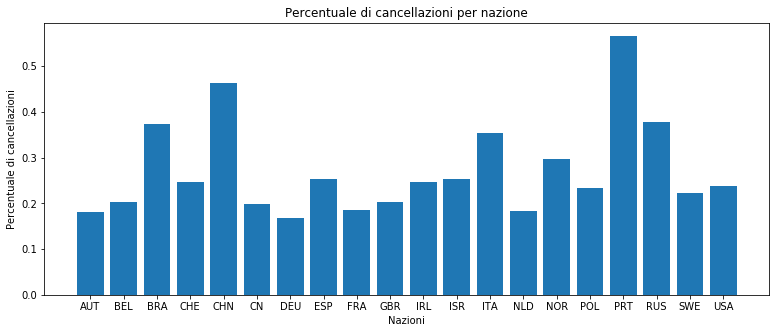

In [584]:
plt.figure(figsize=(13,5))
plt.bar(ccountry.index, ccountry);
plt.title("Percentuale di cancellazioni per nazione")
plt.xlabel("Nazioni")
plt.ylabel("Percentuale di cancellazioni");

- Come possiamo notare dai grafici _'Percentuale di cancellazioni per nazione'_ e _'Percentuale di cancellazioni per mese'_  le percentuali delle nazioni sono molto più variabili delle percentuali dei mesi.
- Possiamo verificare questa intuizione calcolando la deviazione stardad delle due serie.

In [585]:
cmonths.std()

0.038098025716024234

In [586]:
ccountry.std()

0.10468863918729307

- Come si può notare la varianza rispetto ai paesi è più di tre volte di quella rispetto al mese
- Questo dato si può usare per valutare l'importanza di prendere in considerazione una feature piuttosto che l'altra.
- Entrambe le feature non sono di tipo numerico quindi per poterle utilizzare si devono creare tante colonne quanti sono i valori distinti della variabile e per ogni cella registrare un valore binario che indica se l'instanza ha quel valore della feature originale. 
- Secondo il ragionamento fatto in questa Analisi Dati deduciamo intuitivamente che sarebbe più furbo prendere in considerazione tramite questo metodo la variabile _country_ rispetto a _arrival_date_month_ dato che le cancellazioni sembrano variare di conseguenza, quindi dipendervi, in maggior misura.

## Selezione delle feature
- Innanzitutto valutiamo quali delle feature non possono essere utilizzate nella predizione in quanto contengono dati che non sono presenti al momento della prenotazione
    - Eliminiamo anche _bookings_changes_ e _days_in_waiting_list_ perchè supponiamo di voler predirre la possibile cancellazione appena la prenotazione viene inoltrata dal cliente 

In [587]:
hbookings = hbookings.drop(columns = ["adr", "assigned_room_type", "reservation_status", "reservation_status_date", "days_in_waiting_list", "booking_changes"])

- Sostituiamo i valori mancanti (NaN) di tipo numerico con 0 e quelli di tipo oggetto (ovvero le stringhe) con "missing".

In [588]:
for col in hbookings:
    dt = hbookings[col].dtype 
    if dt == int or dt == float:
        hbookings[col].fillna(0, inplace=True)
    else:
        hbookings[col].fillna("missing", inplace=True)

- A questo punto possiamo definire il gruppo di feature che useremo (X) e la feature che invece siamo interessati a predire (y).

In [589]:
X = hbookings.drop(columns = 'is_canceled');
y = hbookings['is_canceled'];

### Feature Numeriche
- Selezioniamo inizialmente solo le colonne numeriche e creiamone una copia.
    - Eliminiamo momentaneamente le colonne numeriche _agent_ e _company_ perchè rappresentano dei codici, quindi in realtà sono categoriche.
- Ho deciso di aggiungere momentaneamente una colonna con il numero totale di notti del soggiorno _stays_in_nights_ per testare le correlazioni.

In [590]:
hbnum = hbookings.select_dtypes(['number']).copy()
hbnum = hbnum.drop(columns=['agent', 'company'])
hbnum = hbnum.assign(stays_in_nights = hbnum['stays_in_week_nights'] + hbnum['stays_in_weekend_nights'])
Xnum = hbnum.drop(columns = 'is_canceled');
pd.set_option('display.max_columns', None)
Xnum.head(5)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,stays_in_nights
0,342,2015,27,1,0,0,2,0.0,0,0,0,0,0,0,0
1,737,2015,27,1,0,0,2,0.0,0,0,0,0,0,0,0
2,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,1
3,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,1
4,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,1,2


- Usando variabili numeriche, possiamo provare ad individuare la correlazione di una variabile con la variabile da predirre _is_canceled_ attraverso un'istogramma _stacked_ che ci mostra, per ogni valore della variabile, quante sono state le prenotazioni cancellate e in quanti casi è stato realmente effettuato il soggiorno.
    - Ad esempio possiamo graficare l'istogramma stacked in base alla settimana di arrivo durante l'anno, creando 12 bins per visualizzare le prenotazioni in ogni mese e in che porzione sono state cancellate.

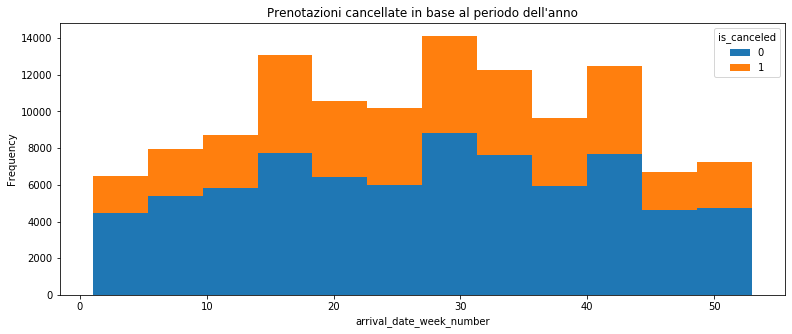

In [591]:
hbnum.pivot(columns="is_canceled")["arrival_date_week_number"].plot.hist(bins=12, stacked=True, figsize=(13,5));
plt.title("Prenotazioni cancellate in base al periodo dell'anno")
plt.xlabel("arrival_date_week_number");

- Usando due variabili numeriche, ad esempio la nuova colonna _stays_in_nights_ e _lead_time_ possiamo investigare sulla loro correlazione in funzione della cancellazione visualizzando un grafico a dispersione di quali sono le prenotazioni cancellate rispetto a queste variabili

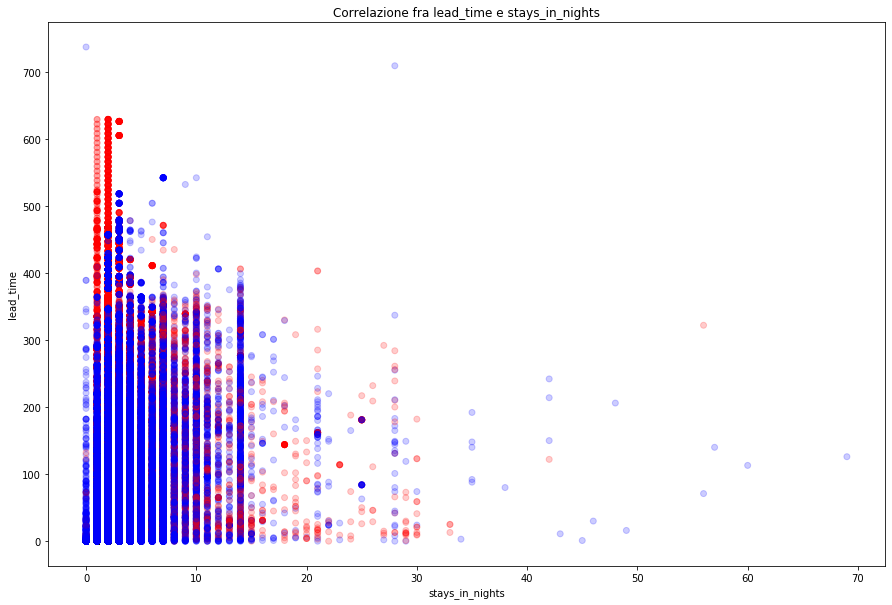

In [592]:
color_map = {0: "blue", 1: "red"}
canceled_colors = hbnum["is_canceled"].map(color_map)
plt.figure(figsize=(15,10))
plt.scatter(hbnum["stays_in_nights"], hbnum["lead_time"], c=canceled_colors, alpha=0.20);
plt.title("Correlazione fra lead_time e stays_in_nights")
plt.xlabel("stays_in_nights")
plt.ylabel("lead_time");

- Dal grafico possiamo notare che la maggior parte delle cancellazioni si verificano con un numero abbastanza alto di notti prenotate (più di 10) o su prenotazioni effettuate e da parecchio tempo (più di un anno), anche se la parziale sovrapposizione dei punti di diverso colore rende difficile giudicare adeguatamente il grafico.
- Inoltre possiamo notare che le due variabili non sono molto correlate dato che non si può evidenziare un comportamento lineare.
- Possiamo rimuovere le colonna _stays_in_nights_.

In [593]:
hbnum = hbnum.drop(columns = 'stays_in_nights');

### Rilevanza delle Feature Numeriche
- Usando la Regressione Lasso, possiamo evidenziare quali sono le feature numeriche più importanti.
- Applichiamo anche la Standardizzazione per uniformare maggiormente le variabili.

In [594]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.03))
])
ynum = hbnum['is_canceled'];
model.fit(Xnum, ynum)
pd.Series(model.named_steps["regr"].coef_, Xnum.columns)

lead_time                         0.098528
arrival_date_year                 0.000000
arrival_date_week_number         -0.000000
arrival_date_day_of_month        -0.000000
stays_in_weekend_nights          -0.000000
stays_in_week_nights             -0.000000
adults                            0.000000
children                          0.000000
babies                           -0.000000
is_repeated_guest                -0.000000
previous_cancellations            0.010476
previous_bookings_not_canceled   -0.000000
required_car_parking_spaces      -0.046999
total_of_special_requests        -0.069500
stays_in_nights                  -0.000000
dtype: float64

- Possiamo notare che feature più rilevanti sono _lead_time, previous_cancellations, required_car_parking_spaces_ e _total_of_special_requests_

### Feature categoriche
- Usiamo il filtro `OneHotEncoder` messo a disposizione da scikit-learn per prendere in considerazione anche le feature categoriche oltre a quelle numeriche.

In [595]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories="auto", sparse=False)
categorical_cols = ["agent", "company", "hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type", "deposit_type", "customer_type"]
Xcat = ohe.fit_transform(X[categorical_cols])

In [596]:
X = np.hstack([Xnum.values, Xcat])

# Classificazione Lineare
- Per risolvere il problema dobbiamo predire a quale classe (cancellata/non cancellata) una qualsiasi istanza appartiene, quindi dobbiamo risolvere un problema di classificazione.
- Cerchiamo dunque di trovare una modello di classificazione lineare.
- Innazitutto dividiamo il nostro Dataset in Training set e Validation set.

In [597]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

## Regressione Logistica
- Proviamo inizialmente ad utilizzare una Regressione Logistica classica, senza Regolarizzazione nè Standardizzazione.

In [598]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7378445611478253

- Notiamo che l'accuratezza sul Validation set è del 73% circa.
- Per avere maggiori informazioni possiamo visualizzare la matrice di confusione sul Validation set e valutare la Recall del modello.

In [599]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm_dataframe = pd.DataFrame(cm, index=['not_canceled', 'canceled'], columns=['not_canceled', 'canceled']) 
cm_dataframe

,not_canceled,canceled
not_canceled,23434,1573
canceled,8860,5930


In [600]:
from sklearn.metrics import precision_score, recall_score, f1_score
recall_score(y_val, y_pred, pos_label=0)

0.9370976126684528

In [601]:
recall_score(y_val, y_pred, pos_label=1)

0.400946585530764

- Notiamo che delle prenotazioni non cancellate il 94% è stato individuato correttamente (23429 prenotazioni), mentre delle prenotazioni cancellate (la classe meno numerosa) solo il 40% è stato predetto correttamente (5931 prenotazioni).
    - Nel caso della prenotazione cancellata la predizione è peggiore di quella casuale.
- Calcoliamo anche la F1 measure che valuta sommariamente sia Recall che Precision.

In [602]:
f1_score(y_val, y_pred)

0.5320055622841251

- Otteniamo una F1 measure del 53%. 

### Selezione delle feature più rilevanti
- Un primo problema con questo approccio è che l'addestramento del modello, seppur molto semplice, è stato abbastanza lento.
- Prima di provare ad applicare altri modelli di addestramento, individuiamo le feature più rilevanti attraverso la Regressione Lasso ed eliminiamo tutte le altre.
- Con un alpha=0.006 otteniamo le 71 feature diverse da 0 più rilevanti della matrice X.

In [603]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.006))
])
model.fit(X, y)
feature_rel = model.named_steps["regr"].coef_
labels = np.hstack([Xnum.columns, ohe.get_feature_names()])
sel_features = pd.Series(feature_rel, labels)
sel_features = sel_features[sel_features != 0]
X = X[:,  np.where(feature_rel == 0, False, True)]

- Rifacciamo lo split del Data set in Training set e Validation set.
    - Ho eseguito due split successivi e tenuto da parte 1/3 dei dati come Test set per poterlo utilizzare sia per i modelli allenati su questo split di Traning set / Validation Set che nello split che farò in seguito con le classi bilanciate.

In [604]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,           # dati da suddividere
    test_size=1/10,    # proporzione: 2/3 training e validation, 1/3 test (confronto fra modelli)
    random_state=41   # seed per la riproducibilità
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

- Proviamo a usare la Regressione Logistica su questa versione ridotta della matrice X.

In [605]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7241254153055812

In [606]:
y_pred = model.predict(X_val)
f1_score(y_val, y_pred)

0.5008839723190383

- F1 measure e score sono abbastanza vicini a quelli ottenuti addestrando il modello con più di 750 feature.

### Standardizzazione e Regolarizzazione
- Proviamo a usare la Standardizzazione ed una Regolarizzazione tipo L2, ad esempio con un iperparametro C=0.1

In [607]:
model_L2 = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LogisticRegression(solver="saga", random_state=42, C=0.1))
])
model_L2.fit(X_train, y_train)
model_L2.score(X_val,y_val)

0.8214255800318284

In [608]:
y_pred = model_L2.predict(X_val)
f1_score(y_val, y_pred)

0.737546163315552

- Notiamo un netto miglioramento nello score di questo modello.
- Proviamo a usare anche una Regolarizzazione L1 mantenendo lo stesso C.

In [609]:
model_L1 = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LogisticRegression(solver="saga", random_state=42, C=0.1, penalty="l1"))
])
model_L1.fit(X_train, y_train)
model_L1.score(X_val,y_val)

0.8211743027054192

In [610]:
y_pred = model_L1.predict(X_val)
f1_score(y_val, y_pred)

0.7370365808597118

- Il punteggio è molto simile a quello della Regolarizzazione precedente.
- Tentiamo con una Regolarizzazione Elastic Net sbilanciata a favore L2, con lo stesso C.

In [611]:
model_net = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LogisticRegression(solver="saga", random_state=42, C=0.1, penalty="elasticnet", l1_ratio=0.2))
])
model_net.fit(X_train, y_train)
y_pred = model_net.predict(X_val)
f1_score(y_val, y_pred)

0.737546163315552

In [612]:
model_net.score(X_val,y_val)

0.8214255800318284

- Anche questo punteggio non si scosta dagli altri.
- Possiamo calcolare i reali intervalli di accuratezza dei modelli creati con un confidenza predefinita del 95% usando le funzioni `conf_interval` e `model_conf_interval`.

In [613]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

from scipy.stats import norm
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y);
    N = X.shape[0];
    Z = norm.ppf((level +1)/2);
    return conf_interval(a, N, Z);

In [614]:
model_conf_interval(model, X_val, y_val, 0.95)

(0.719472789006999, 0.7287299707873705)

In [615]:
model_conf_interval(model_L2, X_val, y_val, 0.95)

(0.817424766449376, 0.8253574536854952)

In [616]:
model_conf_interval(model_L1, X_val, y_val, 0.95)

(0.8171713340036365, 0.825108385372823)

In [617]:
model_conf_interval(model_net, X_val, y_val, 0.95)

(0.817424766449376, 0.8253574536854952)

- Dato l'elevato numero di istanze nel Dataset, il Test set (Validation set in questo caso) è molto ampio, ciò ci permette di produrre degli intervalli di accuratezza dall'ampiezzza ridotta.
- Possiamo anche direttamente confrontare due di questi modelli per verificare l'uno sia effettivamente migliore dell'altro avendo ottenuto uno score migliore usando le funzioni `diff_interval` e `model_diff_val`.
- Prendiamo ad esempio __model_L1__ e __model_L2__ ed una confidenza del 95%.

In [618]:
def diff_interval(a1, a2, N1, N2, Z):
    var = (a1 * (1 - a1))/N1 + (a2 * (1 - a2))/N2
    diff = abs(a1-a2)
    Zvar = Z * np.sqrt(var)
    return diff + Zvar, diff - Zvar

def model_diff_val(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y);
    a2 = m2.score(X, y);
    N = len(X)
    Z = norm.ppf((level +1)/2);
    return diff_interval(a1, a2, N, N, Z)

In [619]:
model_diff_val(model_L1, model_L2, X_test, y_test, 0.95)

(0.00986399355947682, -0.009696475341870632)

- Dato che l'intervallo contiene lo zero, i due modelli possono essere considerati equivalenti con una confidenza così alta.

In [620]:
model_diff_val(model_L1, model_L2, X_test, y_test, 0.60)

(0.004283455148085147, -0.004115936930478958)

- Anche usando una confidenza molto più bassa, non riusciamo a trovare un intervallo che non contiene lo 0 in quanto i due modelli hanno accuratezze molto simili e rimangono equivalenti.
    - Ciò significa che usare una certa Regolarizzazione rispetto a un'altra su questo Data set non è sinificativo.
- Proviamo invece a confrontare il modello senza Regolarizzazione e quello con Regolarizzazione L2 con confidenza del 99%.

In [621]:
model_diff_val(model, model_L2, X_test, y_test, 0.99)

(0.10062021338962615, 0.07292866005036044)

- In questo caso lo 0 non appare nell'intervallo dato che il modello con Standardizzazione e Regolarizzazione è evidentemente meglio di quello senza.

## Cross-validation e Grid Search

- Per trovare il modello con gli iperparametri migliori possiamo fare uso di meccanismi come la **Cross-validation** e la **Grid Search**.
- Eseguiamo la Cross-Validation solamente sui 2/3 del Data set iniziale in modo da mantenere un Test set con 1/3 di Data set che il modello non ha mai valutato per poterne giudicare l'intervallo di accuratezza effettivo. 
- Usiamo la StratifiedFold in modo che in ogni fold ci siano le stesse porzioni di ciascuna classe.

In [622]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    14988
1     8891
Name: is_canceled, dtype: int64
0    14988
1     8890
Name: is_canceled, dtype: int64
0    14987
1     8890
Name: is_canceled, dtype: int64


- Per testare varie combinazioni di iperparametri e selezionare quella che sembra più accurata, usiamo una GridSearch.
- Questa operazione richiede un po' di tempo.

In [623]:
from sklearn.model_selection import GridSearchCV
grid = [
    {
        "scale":[StandardScaler(), None],
        "regr__penalty": ["none"],
    },
    {
        "scale":[StandardScaler(), None],
        "regr__penalty": ["l2", "l1"],
        "regr__C": [0.01, 0.1, 1]
    },
    {
        "scale":[StandardScaler(), None],
        "regr__penalty": ["elasticnet"],
        "regr__C": [0.01, 0.1, 1],
        "regr__l1_ratio": [0.2, 0.5]
    }
]
model_grid = Pipeline([
    ("scale", None),
    ("regr", LogisticRegression(solver="saga", random_state=42))
])
gs = GridSearchCV(model_grid, grid, cv=skf)
gs.fit(X_train, y_train);
gs.best_params_

{'regr__penalty': 'none',
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

- Notiamo che la soluzione migliore non fa uso di Regolarizzazione, solo di Standardizzazione.

- Valutiamo la F1 Measure del modello.

In [624]:
y_pred = gs.predict(X_val)
f1_score(y_val, y_pred)

0.7375677006400787

- Valutiamo l'accuratezza del modello.

In [625]:
gs.score(X_val, y_val)

0.8214255800318284

- Valutiamo l'intervallo di accuratezza del modello con confidenza del 95%.

In [626]:
model_conf_interval(gs, X_val, y_val, 0.95)

(0.817424766449376, 0.8253574536854952)

- Confrontiamo infine con confidenza del 95% il modello ottenuto con uno dei modelli calcolati in precedenza, ad esempio **model_net** con StandardScaler, C=0.1 e l1_ratio = 0.2

In [627]:
model_diff_val(gs, model_net, X_test, y_test, 0.95)

(0.010028000620175568, -0.009525445967357002)

- La confidenza contiene lo 0 quindi i due modelli possono essere considerati equivalenti.
- Proviamo con una confidenza molto più bassa.

In [628]:
model_diff_val(gs, model_net, X_test, y_test, 0.65)

(0.004913210384473535, -0.0044106557316549696)

- Anche abbassando di molto la confideza la situazione non cambia, quindi la Grid Search non è stata particolarmente utile.
- Guardiamo la matrice di confusione del modello migliore ottenuto con la Grid Search.

In [629]:
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=['not_canceled', 'canceled'], columns=['not_canceled', 'canceled']) 

,not_canceled,canceled
not_canceled,20433,2138
canceled,4258,8988


- Possiamo notare che le istanze di classe _not_canceled_ sono classificate abbastanza bene mentre la classificazione di quelle di classe _canceled_ è decisamente più incorretta.

## Bilanciamento delle istanze per classe
- Per dare più importanza alle istanza di classe 1, facciamo **UNDERSAMPLIG** di tale classe usando un set di addestamento che contiene lo stesso numero di istanze di classe _not_canceled_ e _canceled_.
    - Nella lista y _not_canceled_ è rappresentato da 0 e _canceled_ da 1.

In [630]:
canceled_size = y_trainval.value_counts()[1]
y_trainvalar = np.array(y_trainval)
tomantain = np.ones(X_trainval.shape[0], dtype=bool)
notcanceled = 0;
for i, item in enumerate(X_trainval):
    if (y_trainvalar[i] == 0):
        notcanceled = notcanceled + 1
    if (notcanceled > canceled_size and y_trainvalar[i] == 0):
        tomantain[i] = False

In [631]:
X_trainvalsq = X_trainval[tomantain, :]
y_trainvalsq = y_trainval[tomantain]

- Verifichiamo che la matrice ottenuta abbia effettivamente il doppio delle istanze rispetto alla quantità di prenotazioni che sono state cancellate nel Data set preso in considerazione.

In [632]:
canceled_size

39917

In [633]:
X_trainvalsq.shape

(79834, 71)

In [634]:
canceled_size * 2 == X_trainvalsq.shape[0]

True

- Proviamo a ripetere una Regressione Logistica con Standardizzazione e Regolarizzazione su questa matrice e visualizziamone la matrice di confusione per vedere se cambia. 

In [635]:
Xsq_train, Xsq_val, ysq_train, ysq_val = train_test_split(
    X_trainvalsq, y_trainvalsq,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)
modelsq_net = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LogisticRegression(solver="saga", random_state=42, C=0.1, penalty="elasticnet", l1_ratio=0.5))
])
modelsq_net.fit(Xsq_train, ysq_train)
modelsq_net.score(Xsq_val, ysq_val)

0.8179392755148054

In [636]:
y_pred = modelsq_net.predict(Xsq_val)
cm = confusion_matrix(ysq_val, y_pred)
pd.DataFrame(cm, index=['not_canceled', 'canceled'], columns=['not_canceled', 'canceled']) 

,not_canceled,canceled
not_canceled,11006,2321
canceled,2524,10761


In [637]:
f1_score(ysq_val, y_pred)

0.816247582205029

- L'accuratezza si è leggermente abbassata pur rimanendo molto simile a quella ottenuta in precedenza.
- La F1 Measure è decisamente aumentata, infatti come possiamo notare dalla matrice di confusione la classificazione delle prenotazioni canceled è molto più sensata rispetto al modello addestrato su Dataset sbilanciato, dove la distribuzione di questa classe era casuale.
- Proviamo ad effettuare una Grid Search con Cross-Validation su questo Dataset modificato per ottenere gli iperparametri migliori.
- Anche questa operazione richiede un po' di tempo.

In [638]:
skf_sq = StratifiedKFold(3, shuffle=True, random_state=42)
grid = [
    {
        "scale":[StandardScaler(), None],
        "regr__penalty": ["none"],
    },
    {
        "scale":[StandardScaler(), None],
        "regr__penalty": ["l2", "l1"],
        "regr__C": [0.01, 0.1, 1, 10]
    },
    {
        "scale":[StandardScaler(), None],
        "regr__penalty": ["elasticnet"],
        "regr__C": [0.01, 0.1, 1, 10],
        "regr__l1_ratio": [0.2, 0.5, 0.8]
    }
]
model_grid = Pipeline([
    ("scale", None),
    ("regr", LogisticRegression(solver="saga", random_state=42))
])
gs_sq = GridSearchCV(model_grid, grid, cv=skf_sq)
gs_sq.fit(Xsq_train, ysq_train);
gs_sq.best_params_

{'regr__C': 0.1,
 'regr__l1_ratio': 0.8,
 'regr__penalty': 'elasticnet',
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [639]:
gs_sq.score(Xsq_val, ysq_val)

0.8179392755148054

In [640]:
ysq_pred = gs_sq.predict(Xsq_val)
f1_score(ysq_val, ysq_pred)

0.816247582205029

- L'accuratezza e l'F1 measure sono simili a quelli calcolati in precedenza quindi non eravamo lontati dalla combinazione di iperparametri migliore.
- Valutiamo il ranking dei vari modelli in base alla diverse combinazioni di iperparametri.

In [641]:
pd.DataFrame(gs_sq.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__penalty,param_scale,param_regr__C,param_regr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,4.923075,0.393211,0.014730,0.002500,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",0.1,0.8,"{'regr__C': 0.1, 'regr__l1_ratio': 0.8, 'regr_...",0.816199,0.818320,0.812176,0.815565,0.002548,1
8,4.109151,0.242678,0.013602,0.001897,l1,"StandardScaler(copy=True, with_mean=True, with...",0.1,NaN,"{'regr__C': 0.1, 'regr__penalty': 'l1', 'scale...",0.816255,0.818207,0.811950,0.815471,0.002614,2
26,5.315175,1.042057,0.012996,0.001074,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",0.1,0.5,"{'regr__C': 0.1, 'regr__l1_ratio': 0.5, 'regr_...",0.816312,0.818151,0.811950,0.815471,0.002600,2
12,4.230663,0.165954,0.013212,0.001304,l1,"StandardScaler(copy=True, with_mean=True, with...",1,NaN,"{'regr__C': 1, 'regr__penalty': 'l1', 'scale':...",0.816030,0.817982,0.811894,0.815302,0.002538,4
14,3.629595,0.087023,0.012071,0.000052,l2,"StandardScaler(copy=True, with_mean=True, with...",10,NaN,"{'regr__C': 10, 'regr__penalty': 'l2', 'scale'...",0.816142,0.817982,0.811725,0.815283,0.002626,5


- Calcoliamo l'intervallo di accuratezza della soluzioni migliori con confidenza del 95%.

In [642]:
model_conf_interval(gs_sq, Xsq_val, ysq_val, 0.95)

(0.8132571258515837, 0.8225296489599982)

In [643]:
model_2ndbest = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LogisticRegression(solver="saga", random_state=42, penalty="l1", C=1))
])
model_2ndbest.fit(Xsq_train, ysq_train);

In [644]:
model_conf_interval(model_2ndbest, Xsq_val, ysq_val, 0.95)

(0.8131812390387321, 0.8224552493351212)

In [645]:
model_3tdbest = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LogisticRegression(solver="saga", random_state=42, penalty="elasticnet", l1_ratio=0.2, C=1))
])
model_3tdbest.fit(Xsq_train, ysq_train);

In [646]:
model_conf_interval(model_3tdbest, Xsq_val, ysq_val, 0.95)

(0.8132191824082775, 0.8224924491844401)

- Valutiamo se tali modelli possono essere considerati equivalenti con confidenza al 95%.

In [647]:
model_diff_val(gs_sq, model_2ndbest, X_test, y_test, 0.95)

(0.010218307134997138, -0.009548234264572606)

In [648]:
model_diff_val(gs_sq, model_3tdbest, X_test, y_test, 0.95)

(0.010218307134997138, -0.009548234264572606)

- I tre modelli con ranking più alto sono effettivamente equivalenti se usiamo una confidenza del 95%.
- Proviamo a confrontare anche **gs_sq** e **gs**, quindi il modello con classi bilanciate e quello con classi sbilanciate.
    - Il set di dati su cui viene testato è stato estratto all'inizio dell'analisi quindi le sue classi non sono bilanciate ma probabilmente seguono l'andamento generale del Dataset, ovvero con un numero di instanze di classe _not_canceled_ maggiore.

In [649]:
model_diff_val(gs_sq, gs, X_test, y_test, 0.80)

(0.011534909196703337, -0.0013162979227271743)

- Notiamo che i due modelli non si differenziano nemmeno con un affidabilità del 80%.
- Ricordiamo però che tale misura prende in considerazione solamente l'accuratezza, non la F1 measure che nel modello a classi sblianciate è più alta ed è quella che fa la differenza fra i due modelli.
    - Proviamo a calcolare l'equivalenza dei due modelli con confidenza del 99% basandoci sulla F1 measure invece che sullo score.

In [650]:
def model_diff_val_F1(m1, m2, X, y, level=0.95):
    y_pred1 = m1.predict(X)
    a1 = f1_score(y, y_pred1)
    y_pred2 = m2.predict(X)
    a2 = f1_score(y, y_pred2)
    N = len(X)
    Z = norm.ppf((level +1)/2);
    return diff_interval(a1, a2, N, N, Z)

In [651]:
model_diff_val_F1(gs_sq, gs, X_test, y_test, 0.99)

(0.0392610485742939, 0.010192612808129567)

- Come possiamo notare rispetto alla F1 measure il modello **gs_sq** è migliore con affidabilità del 99%.

# Classificazione Non Lineare
- Anche se l'accuratezza non vicina è al 50% (classificazione totalmente casuale), il modello più adatto potrebbe non essere quello lineare.
- Proviamo a usare la Classificazione non lineare sul Training Set bilanciato per provare ad ottenere un'accuratezza migliore con affidabilità del 95%.
- Usiamo _PolynomialFeatures_ per aggiungere delle variabili a quelle già presenti.

In [652]:
from sklearn.preprocessing import PolynomialFeatures
model_deg2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("regr", LogisticRegression(solver="saga", random_state=42))
])
model_deg2.fit(Xsq_train, ysq_train)
model_deg2.score(Xsq_val, ysq_val)

0.675447166691718

- L'accuratezza si è decisamente abbassata quindi probabilmente la classificazione non è di secondo grado, inoltre il tempo di addestramento è abbastanza lungo. 
- Proviamo ad utilizzare un altro metodo.

## Multi-Layer Perceptron
- Usiamo Multi-Layer Perceptron che ci permette di aggiungere uno o più strati di _h_ feature in cui modellare diversamente le nostre ossservazioni prima di giungere all'output finale.
- Usiamo la funzione di attivazione **ReLu**.

In [653]:
from sklearn.neural_network import MLPClassifier
modelMLP = MLPClassifier(hidden_layer_sizes=4, activation="relu")
modelMLP.fit(Xsq_train, ysq_train)
modelMLP.score(Xsq_val, ysq_val)

0.7463926048399219

In [654]:
y_pred = modelMLP.predict(Xsq_val)
f1_score(ysq_val, y_pred)

0.7918966421016929

- Sia l'F1 measure che lo score sono più alti rispetto al modello **gs_sq**.
- Verifichiamo che tale informazione sia statisticamente significativa con un'affidabilità del 95%.

In [655]:
model_diff_val(gs_sq, modelMLP, X_test, y_test, 0.95)

(0.14222288232145458, 0.12044568288501162)

- Il modello **modelMLP** è effettivamente migliore.
- Proviamo a usare Grid Search modificando anche il parametro _batch_size_ per verificare se esiste una soluzione MLP migliore di quella lineare con un'affidabilità abbastanza alta.
- Questa Grid Search richiede un tempo molto lungo.
    - Dato il tempo di addestramento già lungo ho scelto di non inserire come iperparametro da variare anche _max_iter_.

In [656]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(activation="relu"))
])
grid = {
    "mlp__hidden_layer_sizes": [4, 8, (4, 8), (8, 16)],
    "mlp__batch_size":[50, 100, 200],
}
MLPgs = GridSearchCV(model, grid, cv=skf_sq)
MLPgs.fit(Xsq_train, ysq_train);
MLPgs.best_params_

{'mlp__batch_size': 50, 'mlp__hidden_layer_sizes': (8, 16)}

In [657]:
MLPgs.score(Xsq_val, ysq_val)

0.847925747782955

In [658]:
y_pred = MLPgs.predict(Xsq_val)
f1_score(ysq_val, y_pred)

0.8476222749350504

- F1 Measure e score sono entrambi migliori rispetto sia al modello MLP provato in precedenza che a quello trovato con Regressione Lineare.
- Controlliamo che queste differenze siano statisticamente significative con affidabilità del 95%.

In [659]:
model_diff_val(modelMLP, MLPgs, X_test, y_test, 0.95)

(0.17125043762650924, 0.1500495037421147)

- Dato che negli intervalli non è presente lo 0, possiamo dichiarare che **MLPgs** è il modello migliore fra quelli addestrati finora.

## Reti Neurali con Keras

- Utilizziamo le reti neurali di TensorFlow con l'interfaccia Keras per provare a  trovare una soluzione migliore di __MLPgs__.

In [660]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

- Standardizziamo Traning set e Validation set.
- Trasformiamo y_train e y_val per usare degli array che indicano a quale classe appartiene l'instanza invece del valore binario per renderli compatibili con TensorFlow usando la funzione `to_categorical` di Keras.

In [661]:
scaler_X = StandardScaler()
Xscal_train = scaler_X.fit_transform(X_train)
Xscal_val = scaler_X.transform(X_val)
#scaler_y = StandardScaler()
#yscal_train = scaler_y.fit_transform(ysq_train[:, None]).ravel()
#yscal_val = scaler_y.transform(ysq_val[:, None]).ravel()

yt_train = to_categorical(y_train)
yt_val = to_categorical(y_val)

- Proviamo una rete neurale con attivazione _ReLu_ a tre strati con rispettivamente 32, 8 e 2 nodi. 
    - Otteniamo 2 output, ovvero un array con 2 valori per ogni istanza.

In [662]:
Kmodel = Sequential([
    Dense(32, activation="relu", input_dim=Xscal_train.shape[1]),
    Dense(8, activation="relu"),
    Dense(2, activation="softmax")
])
Kmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                2304      
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 18        
Total params: 2,586
Trainable params: 2,586
Non-trainable params: 0
_________________________________________________________________


- La rete che costruiamo ha 2586 parametri, ovvero `71*32 + 32 + 32*8 + 8 + 8*2 + 2`.
- Possiamo procedere ed addestrarla sul nostro modello con una discesa del gradiente stocastica, tale operazione richiede un po' di tempo.

In [663]:
Kmodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
Kmodel.fit(Xscal_train, yt_train, batch_size=50, epochs=20)

Epoch 1/20
71634/71634 [==============================] - 12s 162us/step - loss: 0.3858 - accuracy: 0.8130
Epoch 2/20
71634/71634 [==============================] - 6s 82us/step - loss: 0.3237 - accuracy: 0.8447
Epoch 3/20
71634/71634 [==============================] - 6s 86us/step - loss: 0.3138 - accuracy: 0.8492
Epoch 4/20
71634/71634 [==============================] - 6s 81us/step - loss: 0.3084 - accuracy: 0.8528 0s - loss: 0.3079 - 
Epoch 5/20
71634/71634 [==============================] - 8s 108us/step - loss: 0.3037 - accuracy: 0.8549
Epoch 6/20
71634/71634 [==============================] - 6s 89us/step - loss: 0.3007 - accuracy: 0.8560
Epoch 7/20
71634/71634 [==============================] - 6s 88us/step - loss: 0.2985 - accuracy: 0.8583
Epoch 8/20
71634/71634 [==============================] - 6s 82us/step - loss: 0.2959 - accuracy: 0.8592
Epoch 9/20
71634/71634 [==============================] - 6s 81us/step - loss: 0.2942 - accuracy: 0.8606
Epoch 10/20
71634/71634 [======

- Valutiamo il modello sui dati del Validation Set (bilanciato).

In [664]:
Kmodel.evaluate(Xscal_val, yt_val)

35817/35817 [==============================] - 3s 86us/step


[0.2960367112125348, 0.8608761429786682]

- Otteniamo un'accuratezza dell'85,6%, vicina a quella del modello precedente.
- Controlliamo se i due modelli sono equivalenti con confidenza del 95% sul Test set (sbilanciato come i dati originali).

In [665]:
Xscal_test = scaler_X.transform(X_test)
yt_test = to_categorical(y_test)
a1 = Kmodel.evaluate(Xscal_test, yt_test)[1];
a2 = MLPgs.score(X_test, y_test);
N = len(X_test)
level = 0.95
Z = norm.ppf((level +1)/2);
diff_interval(a1, a2, N, N, Z)

11939/11939 [==============================] - 1s 101us/step


(0.02511483119776062, 0.007048667541169919)

- L'intervallo contiene lo 0 quindi la differenza dell'accuratezza dei due modelli non è statisticamente rilevante.

# Conclusione

- I modelli più soddisfacenti ottenuti dall'analisi sono quelli che utilizzano funzioni di attivazione su più strati:
    - **MLPgs** che utilizza MLP con Grid Search per estrarre la combinazione di iperparametri migliore fra un range di possibilità.
    - **Kmodel** che utilizza TensorFlow con una Rete costruita su tre strati usando un numero di nodi casuale (facendo altri tentativi è possibile che l'accuratezza migliori).
- Tali modelli sono equivalenti con affidabilità del 95%, quindi anche se Kmodel ha uno score leggermente superiore ciò non è rilevante.

## Interpretazione
- Possiamo visualizzare i coefficienti e le intercette dei parametri di entrambi i modelli che risultano più accurati.
- Nel caso ci **Kmodel** otteniamo:
    - una matrice `71 x 32` per i pesi del primo strato
    - un vettore con i `32` bias del primo strato 
    - una matrice `32 x 8` con pesi del secondo strato 
    - un vettore con gli `8` bias del secondo strato
    - una matrice `8 x 2` per i pesi dell'output
    - un vettore di `2` elementi con i bias di output

In [666]:
Kmodel.get_weights()

[array([[ 0.09835638, -1.4270738 ,  0.25412765, ...,  0.13480404,
          0.06099843, -1.0679125 ],
        [ 0.69601387, -0.09001047, -0.07280458, ..., -0.44356155,
         -0.697138  ,  0.04622587],
        [ 0.41741422, -0.11181132, -0.29943618, ...,  0.7720382 ,
         -0.06436125, -0.08913923],
        ...,
        [-0.5143493 , -0.01633811, -0.15073135, ..., -0.25577262,
         -0.04265362,  0.26690504],
        [ 0.17898245,  0.09575053, -0.02604941, ...,  0.5986197 ,
         -0.23024458, -0.01727385],
        [ 0.1842543 ,  0.10996938, -0.29870412, ..., -0.53690076,
          0.02355478,  0.10647229]], dtype=float32),
 array([ 0.09373539, -0.27835086,  0.24677996, -0.15357248, -0.03437631,
        -0.04250074, -0.14800252,  0.04141244,  0.3602932 , -0.23366871,
        -0.25995952, -0.10440576, -0.00795077,  0.00688174, -0.17480887,
         0.00483486, -0.3855017 , -0.15365122, -0.18310054,  0.05844958,
        -0.12833522, -0.15060672,  0.11549915, -0.17550196, -0.233

- Invece con **MLPgs** abbiamo:
    - _coefs_ con:
        - una lista di 71 vettori di 8 elementi che rappresentano i pesi dati alle 71 feature iniziali per formare le variabili del primo layer
        - una lista di 8 vettori di 16 elementi che rappresentano i pesi dati alle 8 variabili del primo layer per formare le variabili del secondo layer
        - una lista di 16 vettori con un solo elemento che indicano i pesi delle 16 variabili del secondo layer nell'output finale
    - _intercepts_ con:
        - un vettore di 8 elementi con i bias delle variabili del primo layer
        - un vettore di 16 elementi con i bias delle variabili del secondo layer
        - il bias dell'output finale

In [667]:
MLPgs.best_estimator_.named_steps['mlp'].coefs_

[array([[ 3.58436760e-02, -3.24801807e-01,  5.04319061e-01,
          2.86035155e-01,  2.30328552e-01,  1.27077529e+00,
         -1.72390474e+00,  4.51869048e-01],
        [-7.85108389e-01, -6.89126014e-01, -1.48548452e+00,
          1.71300952e-01, -1.17899385e+00, -7.75384485e-01,
         -4.27008067e-01, -7.57906578e-01],
        [-3.67754054e-01, -8.52480781e-02, -5.07261695e-01,
          1.34636619e-02, -3.46329420e-01, -2.72807829e-01,
         -6.02233472e-02, -5.51483614e-01],
        [-3.56793458e-02, -6.36595808e-02,  4.99918269e-02,
          1.73465143e-02,  1.00838354e-02, -1.38308694e-01,
          1.16016330e-01, -4.02974094e-01],
        [-1.07185344e-02, -5.03141760e-02,  1.40123111e-01,
         -1.12897935e-02,  6.89858422e-02, -3.20093768e-02,
          1.77958871e-01, -5.47532439e-01],
        [-1.82785348e-02, -1.16892049e-02, -4.88957418e-03,
         -6.11444915e-03,  1.17137391e-01,  2.73463562e-02,
          3.05672044e-02,  2.64364683e-01],
        [-3.8003

In [668]:
MLPgs.best_estimator_.named_steps['mlp'].intercepts_

[array([-0.5490244 , -0.09915449, -0.67720958, -0.30232561,  0.16062896,
         0.32776962,  0.22067285, -0.47633095]),
 array([-3.00301863e-02,  4.51295967e-01, -4.39042511e-04, -9.11556372e-02,
         2.12679603e-02,  7.36964602e-01, -1.41204007e-01,  7.40172691e-01,
        -1.95428253e-03, -3.59936402e-01,  1.22456053e+00, -6.90344897e-01,
         2.07700781e-02, -1.11405294e+00, -5.72118771e-02, -2.96737944e-01]),
 array([-0.09250785])]

- Dato che entrambi i modelli sono di reti neurali a più strati, i pesi delle variabili non si possono interpretare intuitivamente per valutare quali sono le feature con maggiore rilevanza nella predizione.
    - Non si riesce a capire in che misura le feature sono correlate con la variabile da predire.

- Possiamo però interpretare il risultato del modello lineare migliore **gs_sq** prendendo in considerazione i pesi assegnati alle feature selezionate.

In [669]:
pd.Series(gs_sq.best_estimator_.named_steps['regr'].coef_.T.reshape(71,), sel_features.index).sort_values()

required_car_parking_spaces      -1.600002
total_of_special_requests        -0.629993
x9_No Deposit                    -0.559197
previous_bookings_not_canceled   -0.319920
is_repeated_guest                -0.212145
x7_TA/TO                         -0.170854
x7_Direct                        -0.160417
x6_Offline TA/TO                 -0.136335
x5_DEU                           -0.132751
x0_28.0                          -0.103974
x2_Resort Hotel                  -0.097597
x0_0.0                           -0.096583
x5_FRA                           -0.087669
x5_BEL                           -0.079973
x8_A                             -0.074453
x5_GBR                           -0.062650
x0_152.0                         -0.059138
x0_7.0                           -0.054954
x0_40.0                          -0.052469
x4_Undefined                     -0.050800
x5_AUT                           -0.048965
x5_NLD                           -0.046108
x0_11.0                          -0.041340
x1_154.0   

- Le feature che determinano l'aumento maggiore della probabilità di cancellazione sono:
    - *previous_cancellations*: una cancellazione precedente
    - *x5_PRT*: il portogallo come paese di provenienza
    - *x9_Non Refund*: soprendentemente il fatto che sia stato effettuato un pagamento completo
    - *x0_9.0*: l'agente numero 9

- Le feature che aumentando fanno diminuire in maniera rilevante la probabilità di cancellazione sono:
    - *required_car_parking_spaces*: il numero di posti auto richiesto
    - *total_of_special_requests*: le richieste speciali
    - *x9_No Deposit*: sorprendentemente il fatto che non sia stato fatto alcun pagamento

- Inoltre possiamo notare che:
    - Sicuramente il City Hotel avrà più cancellazioni rispetto al Resort Hotel, infatti il fatto che il soggiorno sia nel City Hotel contribuisce positivamente alla cancellazione mentre il fatto che sia nel Resort Hotel contribuisce negativamente.
    - All'incrementare del numero di persone (che siano adulti o bambini) la probabilità di cancellazione aumenta.
    - Il fatto che il soggiorno sia stato prenotato tramite un'agenzia o un tour operator diminuisce in modo abbastanza significativo la probabilità di cancellazione.